In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
sys.path.append("..")
from tqdm import tqdm

plt.style.use("../config/custom_plt.mplstyle")

In [2]:
labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/out1_node_feature_label.txt", 
                     sep="\t")

labels = pd.concat([labels['node_id'], 
                    labels['label'], 
                    labels['feature'].str.split(',', expand=True).astype(int)], axis=1)

labels.columns = ['id', 'label', *[f'f{i}' for i in range(1703)]]
labels = labels[['id', 'label']]
labels.head()

,id,label
0,0,1
1,1,2
2,2,2
3,3,2
4,4,1


In [3]:
categories = labels['label'].unique()
colormap = cm.get_cmap('Set1', len(categories))

/tmp/ipykernel_701299/3370728750.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Set1', len(categories))


In [4]:
category_to_colormap = dict(zip(categories, range(len(categories))))
category_to_colormap

{1: 0, 2: 1, 0: 2, 3: 3, 4: 4}

## Exploring node features

In [5]:
from sklearn.metrics.pairwise import *

features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/out1_node_feature_label.txt", 
                     sep="\t")

features = pd.concat([features['node_id'], 
                      features['label'], 
                      features['feature'].str.split(',', expand=True).astype(int)], axis=1)

features.columns = ['id', 'label', *[f'f{i}' for i in range(1703)]]

features.drop('label', axis=1, inplace=True)
features.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f1693,f1694,f1695,f1696,f1697,f1698,f1699,f1700,f1701,f1702
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [6]:
import networkx as nx

g = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/out1_graph_edges.edge",
                     nodetype=int)
gcc_edges_idx = list(g.nodes)

gcc_edges_idx.sort()
gcc_edges_idx[:5]

[0, 1, 2, 3, 4]

In [7]:
data = features.merge(labels, on="id")
data.id = data.id.astype(str)

data

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f1694,f1695,f1696,f1697,f1698,f1699,f1700,f1701,f1702,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,246,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
247,247,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
248,248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
249,249,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


## Dimensional reduction of the nodes' features using UMAP

In [8]:
from sklearn import preprocessing
from sklearn.utils import shuffle


X = data.drop(["id", "label"], axis=1).values

le = preprocessing.LabelEncoder()
y = le.fit_transform(data['label'].values)

X[:5], y[:5]

(array([[0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 1, 0]]),
 array([1, 2, 2, 2, 1]))

In [ ]:
np.mean(X.sum(axis=1))

In [ ]:
%%time
from sklearn.model_selection import train_test_split
from umap.umap_ import UMAP
np.random.seed(12)

reducer = UMAP(metric='cosine', random_state=61)

X_umap = reducer.fit_transform(X)
X_umap.shape

Text(0.5, 1.0, 'UMAP dim=2')

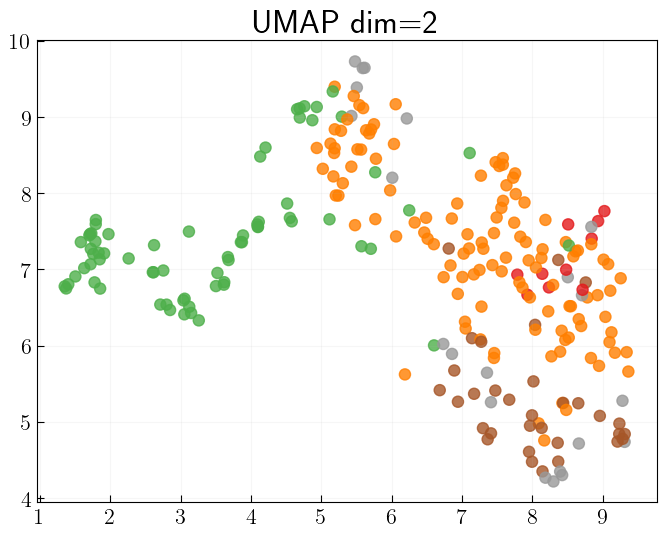

In [10]:
from matplotlib.lines import Line2D

plt.scatter(X_umap[:, 0], X_umap[:, 1], color=[colormap(i) for i in y], alpha=0.8)
plt.title('UMAP dim=2')

### Check non-euclidean embeddings

https://umap-learn.readthedocs.io/en/latest/embedding_space.html

**Spherical embeddings**

In [11]:
sphere_mapper = UMAP(metric='cosine', output_metric='haversine', random_state=61).fit(X) 

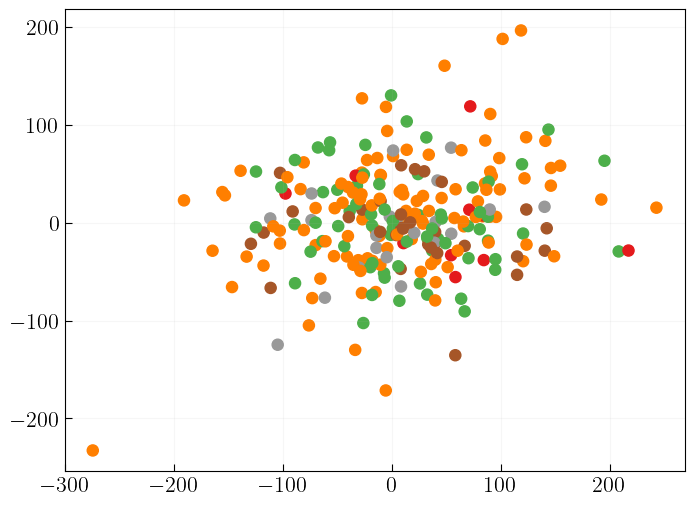

In [12]:
plt.scatter(sphere_mapper.embedding_.T[0], sphere_mapper.embedding_.T[1], c=[colormap(i) for i in y])

In [13]:
xx = np.sin(sphere_mapper.embedding_[:, 0]) * np.cos(sphere_mapper.embedding_[:, 1])
yy = np.sin(sphere_mapper.embedding_[:, 0]) * np.sin(sphere_mapper.embedding_[:, 1])
zz = np.cos(sphere_mapper.embedding_[:, 0])

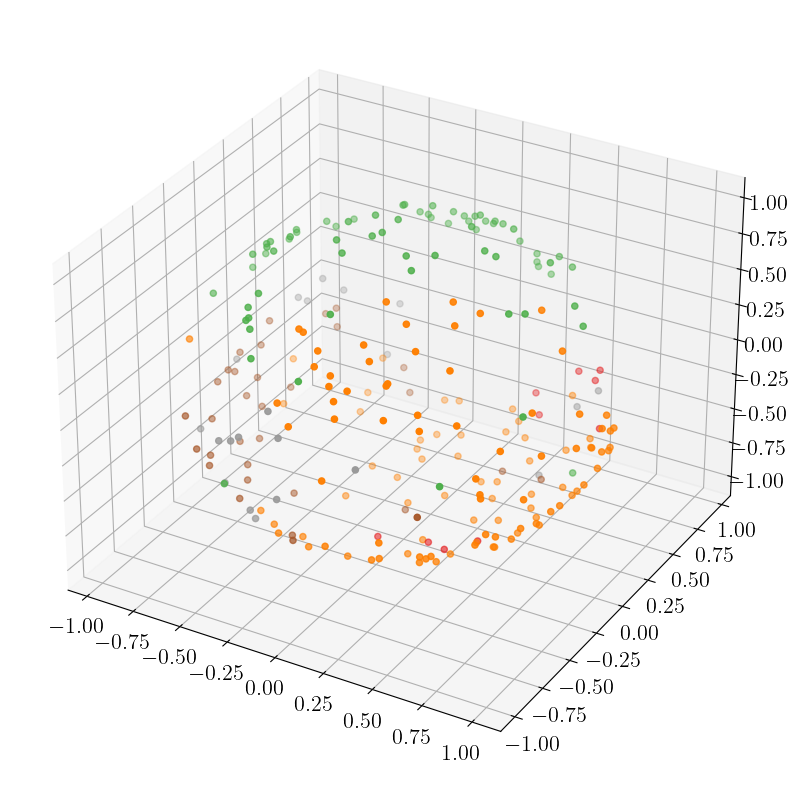

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx, yy, zz, c=[colormap(i) for i in y])

In [15]:
vectors = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1), zz.reshape(-1, 1)), axis=1)

In [16]:
idx = data['id'].values
idx
# np.c_[idx, vectors]

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
       '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67',
       '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78',
       '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89',
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100',
       '101', '102', '103', '104', '105', '106', '107', '108', '109',
       '110', '111', '112', '113', '114', '115', '116', '117', '118',
       '119', '120', '121', '122', '123', '124', '125', '126', '127',
       '128', '129', '130', '131', '132', '133', '134', '135', '136',
       '137', '138', '139', '140', '141', '142', '143', '144

In [17]:
vectors[:10]

array([[ 0.37921375,  0.76279116,  0.523781  ],
       [ 0.7526936 , -0.48881242, -0.44103822],
       [-0.1946818 , -0.7713482 , -0.6059051 ],
       [ 0.4671065 , -0.35956618,  0.8077894 ],
       [-0.28161478, -0.10901756,  0.95331436],
       [-0.17825975,  0.5687466 ,  0.8029637 ],
       [-0.60172015,  0.57404476,  0.5553426 ],
       [-0.4810154 , -0.5364743 ,  0.69341147],
       [ 0.9187938 ,  0.2689891 , -0.2888993 ],
       [-0.01878505, -0.20174904, -0.9792571 ]], dtype=float32)

In [18]:
# F-Mercator

# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/umap/umap_wisconsin_spherical_positions.txt", 'w') as f:
#     for i, v in zip(idx, vectors):
#         f.write(f'{i} {" ".join(map(str, v))}\n')

In [22]:
%%time

sphere_mapper = UMAP(metric='cosine', output_metric='haversine', random_state=2).fit(X)
xx = np.sin(sphere_mapper.embedding_[:, 0]) * np.cos(sphere_mapper.embedding_[:, 1])
yy = np.sin(sphere_mapper.embedding_[:, 0]) * np.sin(sphere_mapper.embedding_[:, 1])
zz = np.cos(sphere_mapper.embedding_[:, 0])
vectors2 = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1), zz.reshape(-1, 1)), axis=1)

CPU times: user 3.13 s, sys: 0 ns, total: 3.13 s
Wall time: 13.3 s


100%|██████████| 251/251 [00:06<00:00, 39.59it/s]


The best Z-axis rotation angle:  5.898500492454305


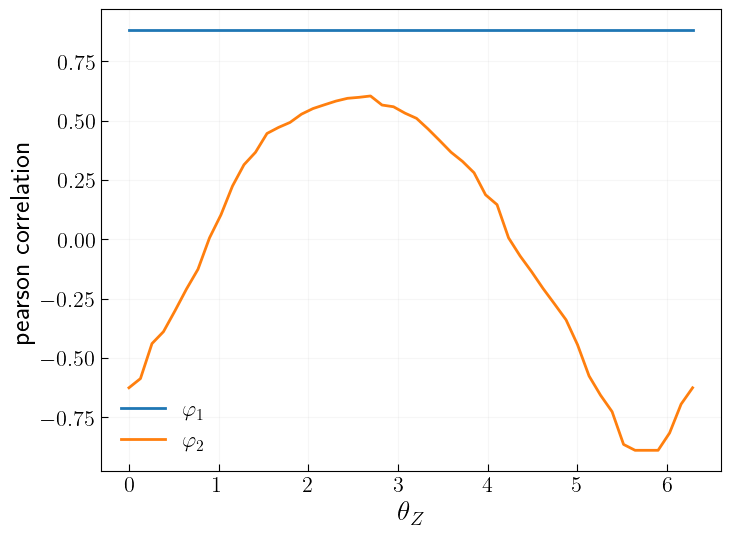

In [23]:
from lib.check_inferred_embeddings import *

real_coords_all, inf_coords_all, real_coords_spherical, inf_coords_spherical = \
    apply_pipeline_matrix_with_loading_and_rotate_all_euclidean_use_all_nodes(vectors, vectors2, )

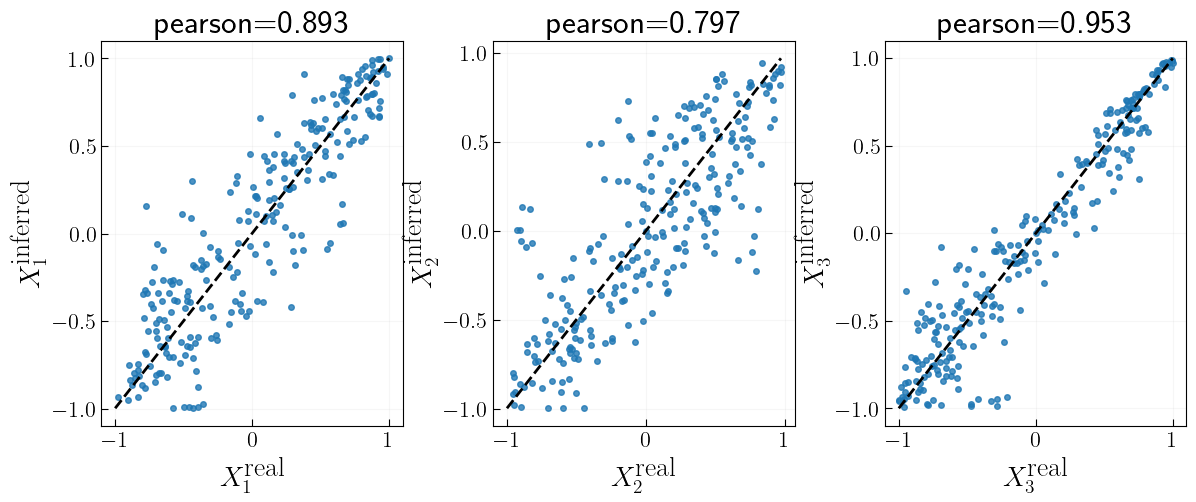

In [24]:
plot_euclidean_coordinates_comparison(inf_coords_all, real_coords_all)